In [1]:

from skimage import io, exposure
import os
import matplotlib.pyplot as plt

from PIL import Image
from PIL.TiffTags import TAGS

import numpy as np

from scipy.ndimage import gaussian_filter, sobel

from skimage import morphology

import glob

import cv2


In [2]:
def local_variance_filter(image,radius=20):
   # time1 = time.time()
    kernel = morphology.disk(radius)
    variance = np.zeros(image.shape)
    for i in np.arange(radius,image.shape[0]-radius):
        for j in np.arange(radius,image.shape[1]-radius):
            pixels = image[i-radius:i+radius+1,j-radius:j+radius+1] * kernel
            variance[i,j] = np.var(pixels[kernel==1])
   # print(str(time.time()-time1)+" s ")
    return variance

In [3]:
# Getting metadata for small image (resolution)
def get_metadata(im_small):
       
    x_res = 21333
    
    return x_res

In [4]:


def distance_two_images(im1, im2):
    """ the euclidean square distance of two images in terms of intensity is calculated
    :im1 np.array of the big image
    :im2 np.array of the small image   """
    
    (height, width) = np.shape(im1)
    (h, w) = np.shape(im2)
    d = np.empty((height - h, width - w))
    
    for row in range(height - h):
        for col in range(width - w):
            d[row,col] = np.sum( np.square( np.subtract(im1[0+row : h+row, 0+col : w+col] , im2) ))
    
    return d



In [5]:


def position_of_min(d):
    """ determine the position of minimum
    :d np.array of distances """
    
    result = np.where(d == np.amin(d))
    print("the minimum distance is: ", np.amin(d))
    print('Tuple of arrays returned : ', result)
    
    return result



In [21]:
import tifffile as tiff


cells = ['cell13']
small_im_type = ['TP','YM'] # can be 'TP' for 'topo' or 'YM'
large_im_type = 'BF' # can be 'BF' or 'IC' for 'ICM'
data_folder = '/monocytes/'
print(len(small_im_type))
px_large = 9.4e-8  #(Hamamatsu camera - for ICM images) - this will determine rescaling (it will be rounded to integer based on the resolution of the small image that is encoded in the tif metadata)

var_filt_radius = 3 # radius for variance filtering
perc_threshold = 90 # percentile threshold for binarsising filtered result
all_im_small=[]
all_im_small_np=[]

thr_overlay_vis = 5 # threshold for visualising overlay (applied to small image)
for i in range(1):
    for j in range(len(small_im_type)):
        im_small_filename = glob.glob(os.getcwd() + data_folder + f'{cells[i]}_{small_im_type[j]}*.tif')
        im_large_filename = glob.glob(os.getcwd() + data_folder + f'{cells[i]}_{large_im_type}*.tif')
        # loading
        im_small = tiff.imread(im_small_filename)
        im_large = tiff.imread(im_large_filename)
        all_im_small.append(im_small)

# loading metadata (small)
        x_res = get_metadata(im_small)

        im_small_np = np.rot90(np.asarray(im_small), k=3)
        im_large_np = np.asarray(im_large)
        all_im_small_np.append(im_small_np)
# dealing with resolution
        px_large = 9.4e-8  #(Hamamatsu camera - for ICM images)
        px_small = 1/float(x_res) * 10**(-2)
        resc_rat = round(px_small/px_large)

        print('\n \n \n Rounded ratio between resolutions: ', round(resc_rat, 4))




2

 
 
 Rounded ratio between resolutions:  5

 
 
 Rounded ratio between resolutions:  5


In [7]:
all_im_small

[array([[1.9789919e-01, 1.1491422e+01, 1.1407242e+01, ..., 1.1898812e+01,
         1.1877932e+01, 1.9789919e-01],
        [1.1433142e+01, 1.1491422e+01, 1.1433142e+01, ..., 1.1898812e+01,
         1.1891542e+01, 1.1877932e+01],
        [1.1048412e+01, 1.1376852e+01, 1.1376852e+01, ..., 1.1640742e+01,
         1.1877932e+01, 1.1829452e+01],
        ...,
        [1.9789919e-01, 1.3267700e-01, 1.2379600e-01, ..., 4.0693700e-01,
         4.0693700e-01, 3.3008099e-01],
        [1.3267700e-01, 0.0000000e+00, 8.5279997e-03, ..., 2.4661900e-01,
         3.0063400e-01, 2.8413999e-01],
        [1.9789919e-01, 1.3267700e-01, 1.2379600e-01, ..., 2.2674000e-01,
         2.2674000e-01, 1.9789919e-01]], dtype=float32),
 array([[0.       , 5.875618 , 5.875618 , ..., 5.876565 , 5.876565 ,
         0.       ],
        [5.8469963, 5.906266 , 5.9034553, ..., 5.9014783, 5.9052243,
         5.9014783],
        [5.8481693, 5.875618 , 5.9214716, ..., 5.9155164, 5.9155774,
         5.9052243],
        ...,
   

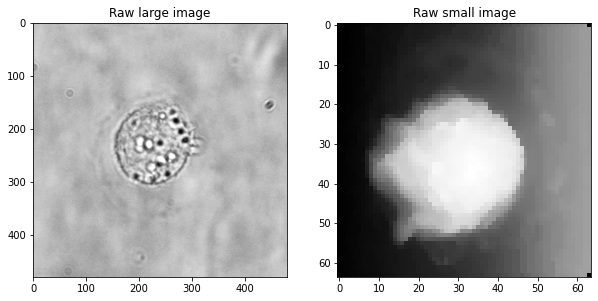

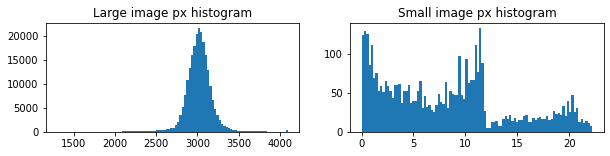

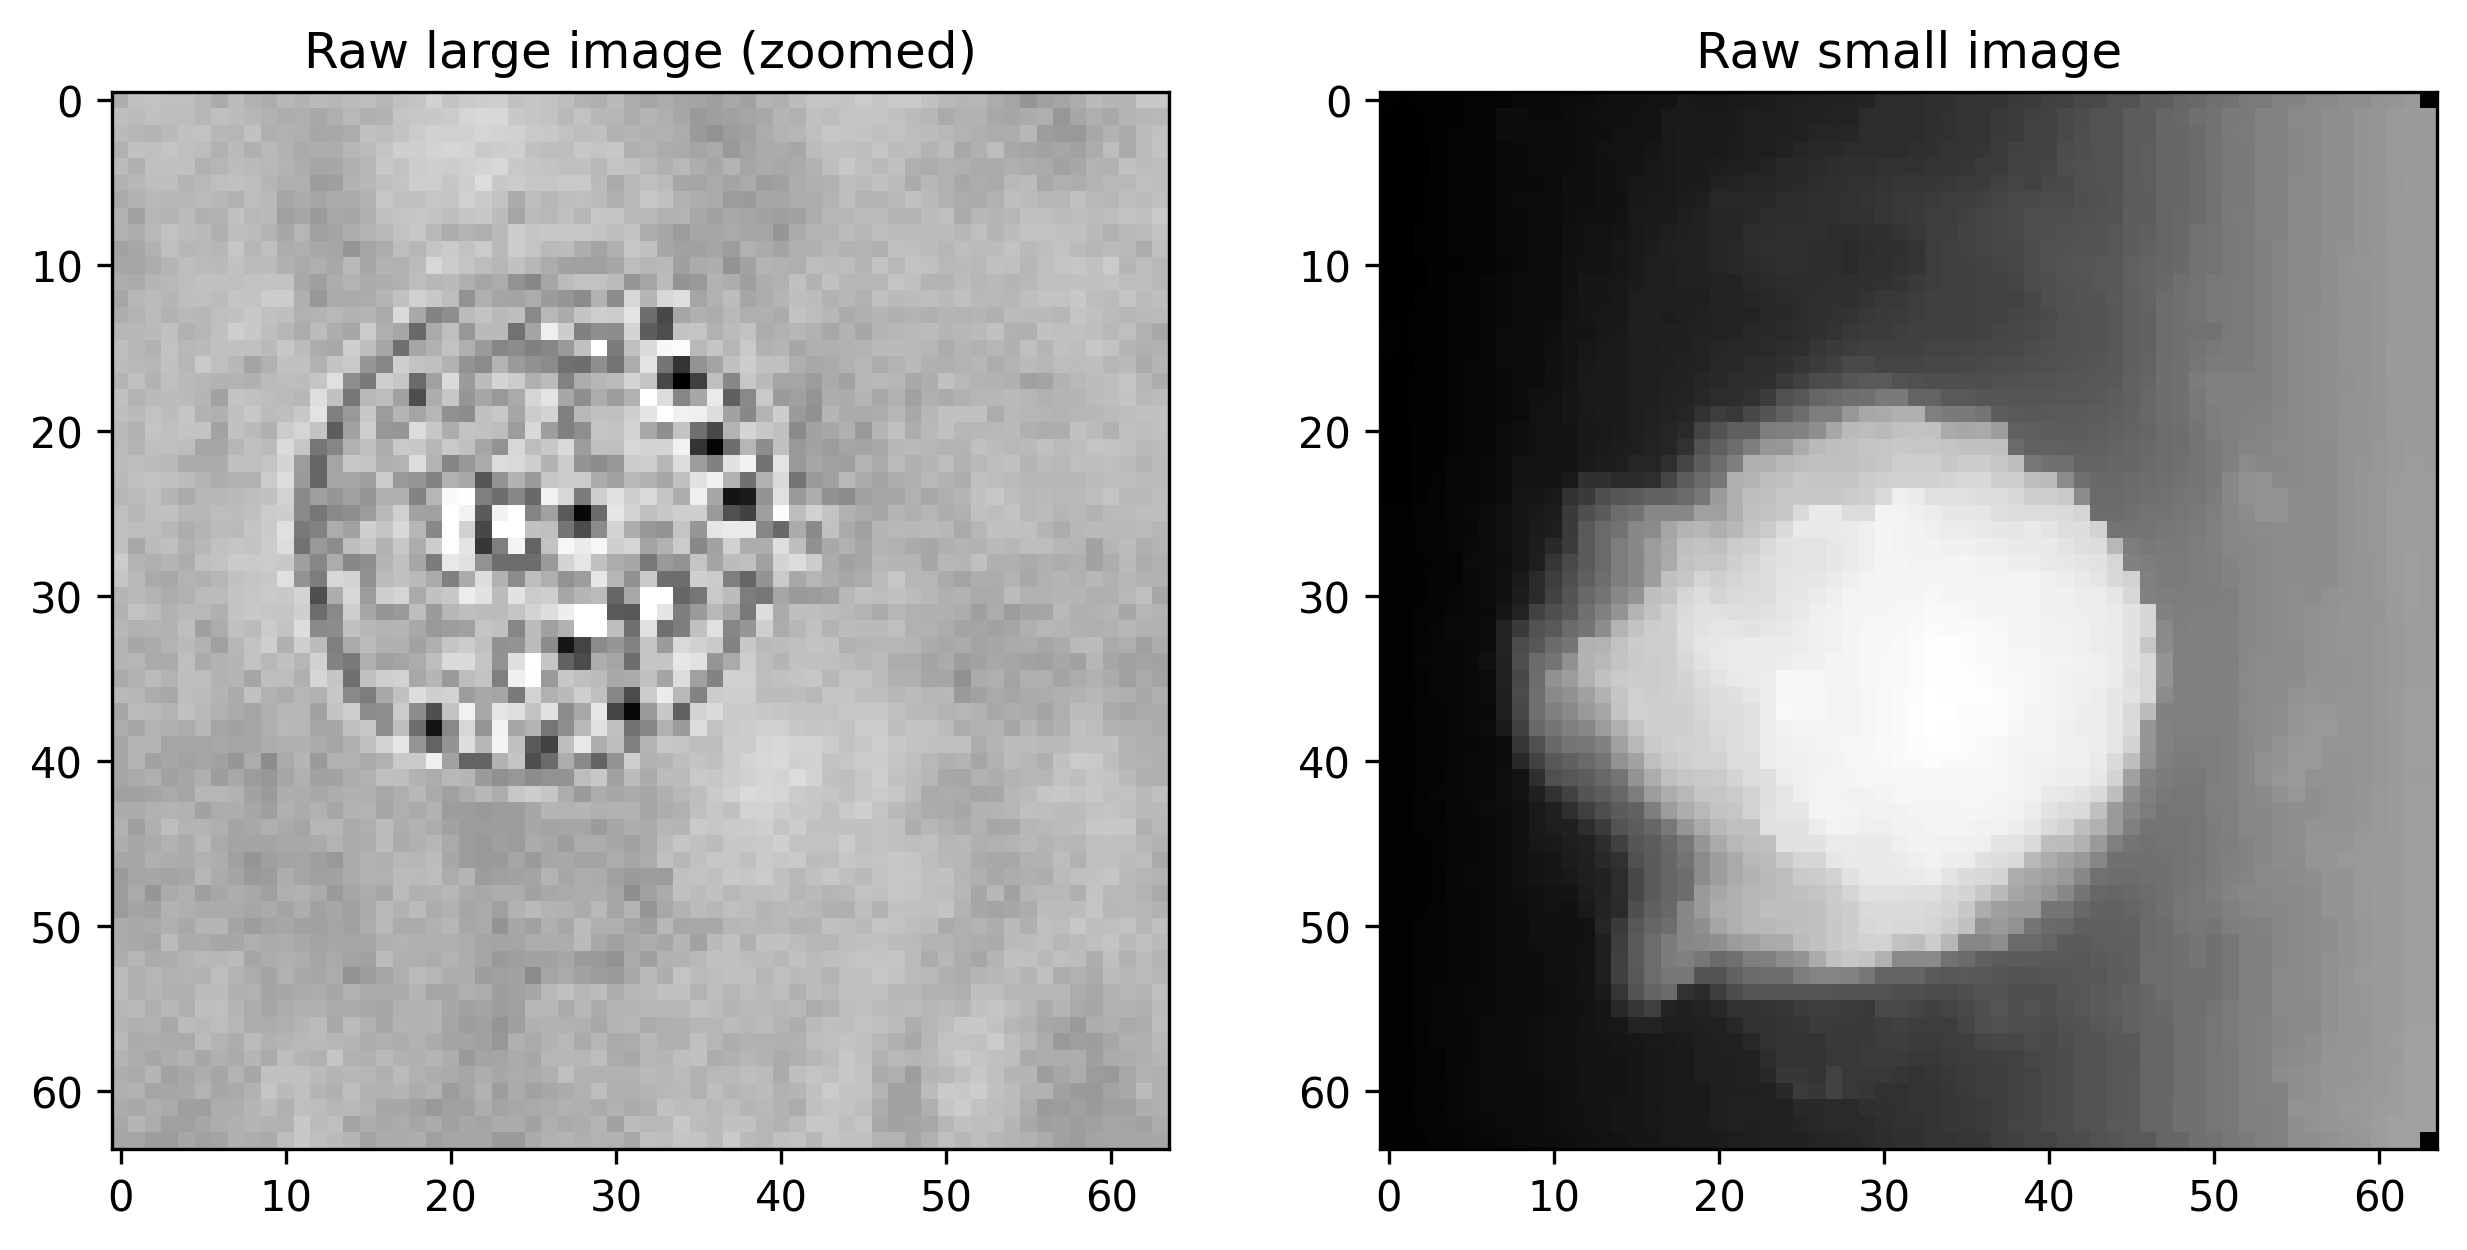

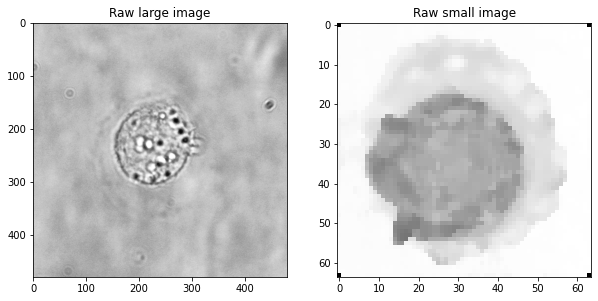

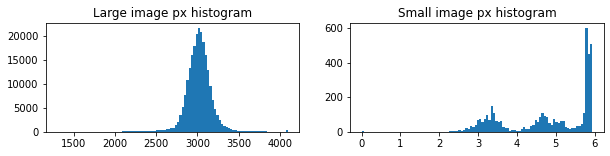

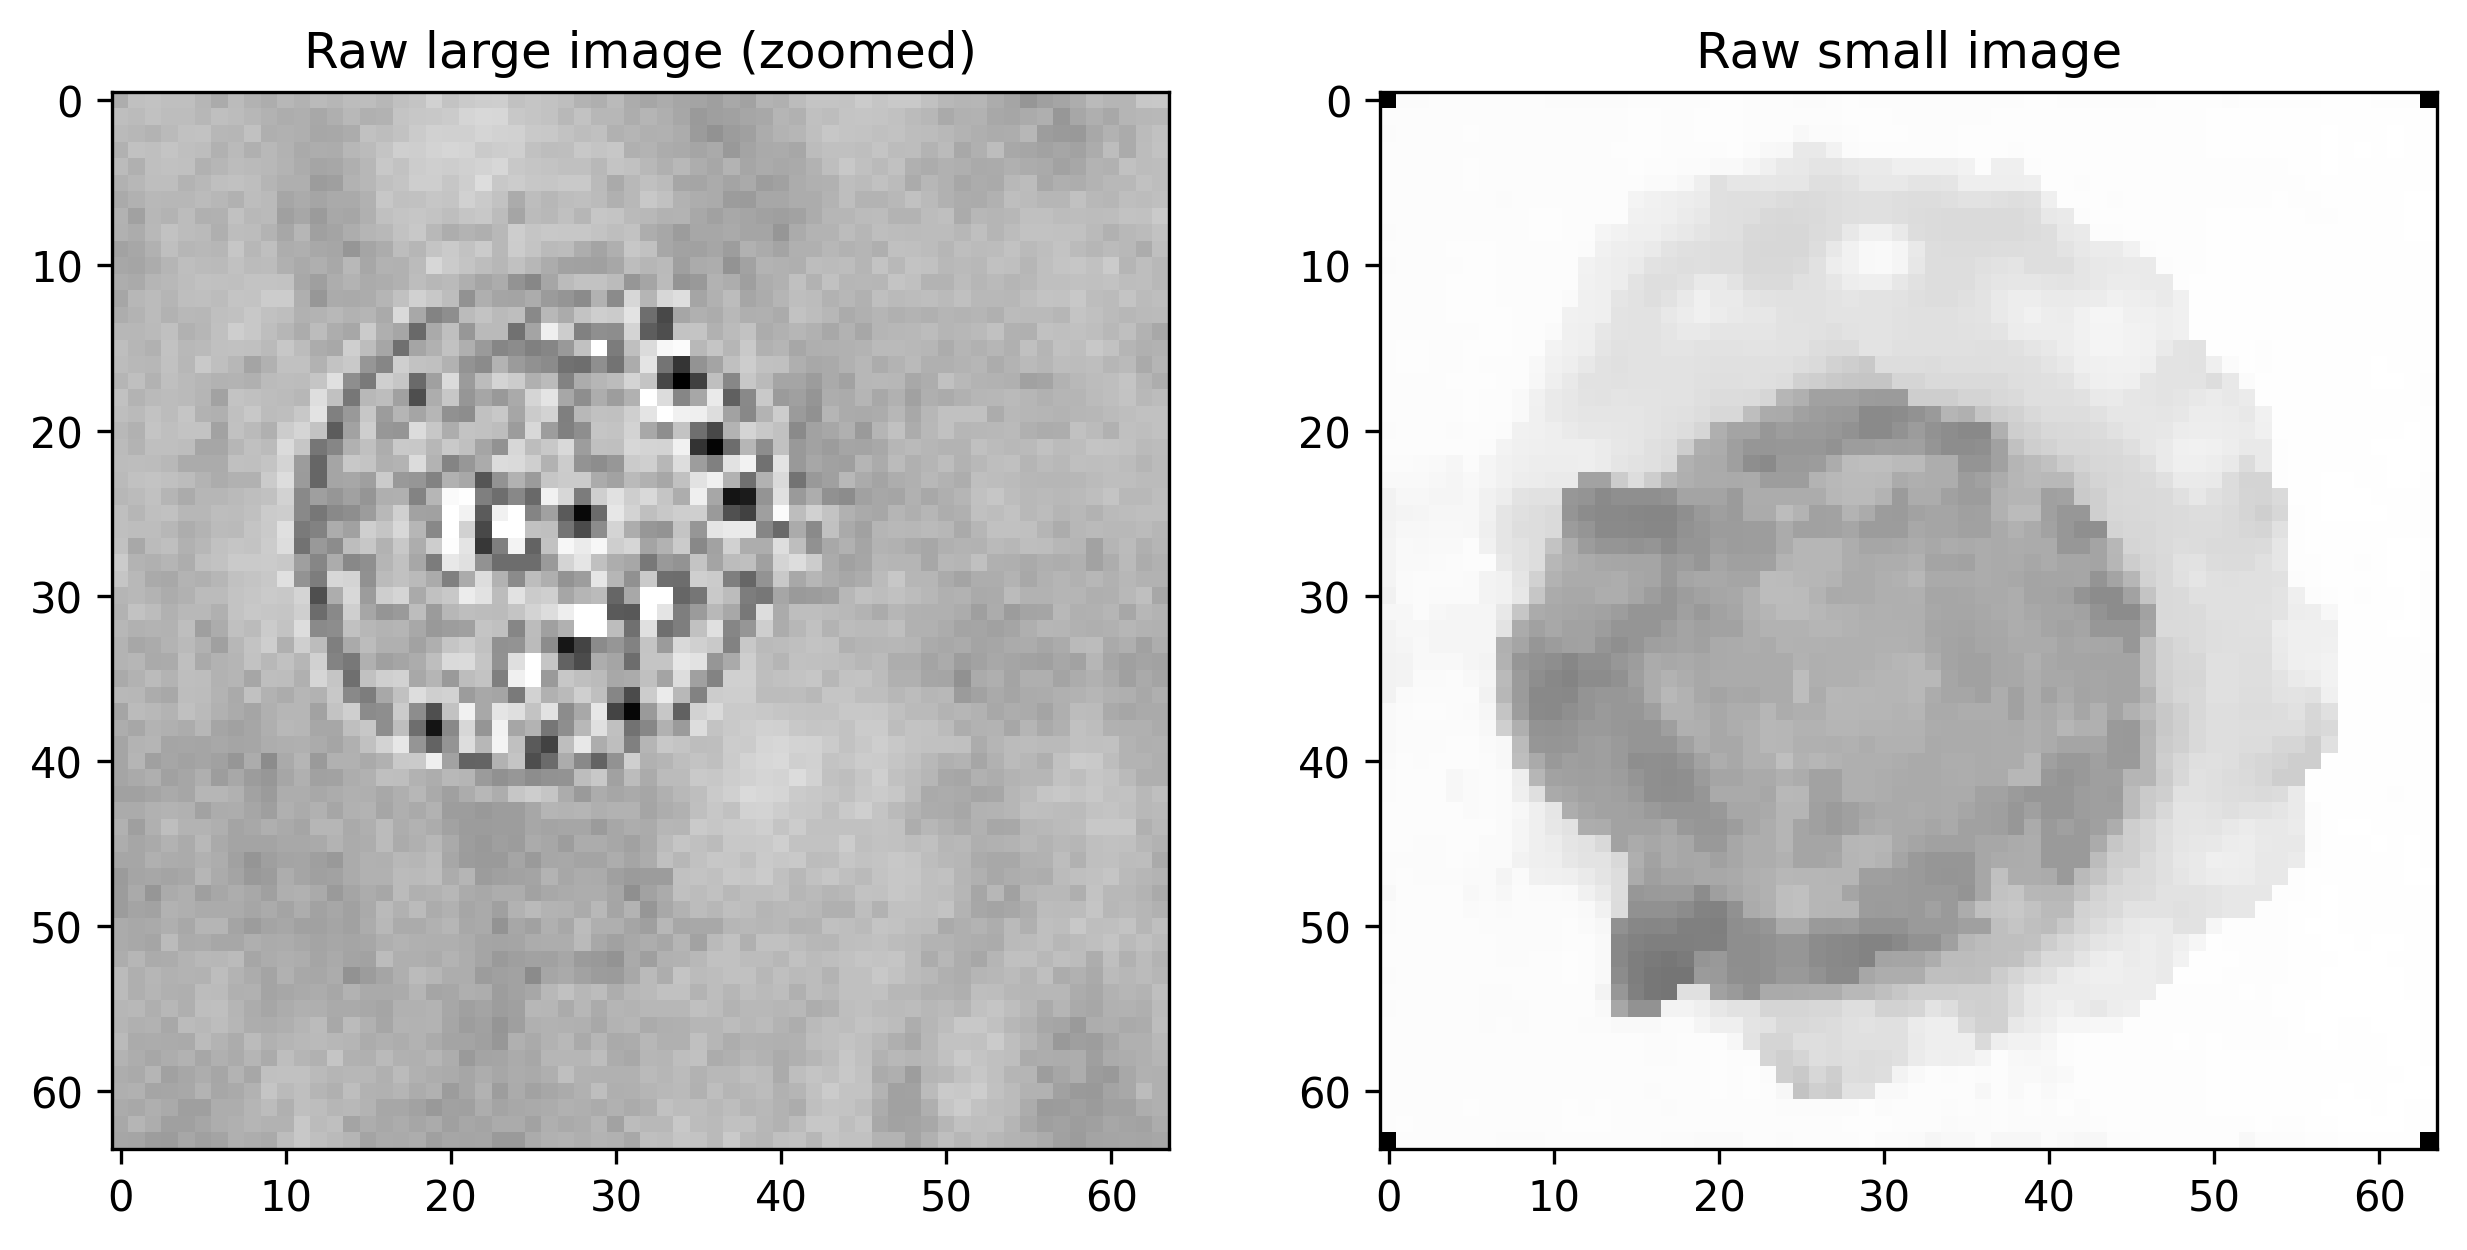

In [8]:

for im_small_np in all_im_small_np:
# plotting original images and their histograms
    _,axs = plt.subplots(1,2, figsize=(10,20))
    axs[0].imshow(im_large_np, cmap='Greys_r')
    axs[1].imshow(im_small_np, cmap='Greys_r')
    axs[0].set_title('Raw large image')
    axs[1].set_title('Raw small image')

    _,axs = plt.subplots(1,2, figsize=(10,2))
    axs[0].hist(im_large_np.flatten(), 100)
    axs[1].hist(im_small_np.flatten(), 100);
    axs[0].set_title('Large image px histogram')
    axs[1].set_title('Small image px histogram')

    _,axs = plt.subplots(1,2, figsize=(10,20), dpi=300)
    axs[0].imshow(im_large_np[100:(100+64*resc_rat):resc_rat, 100:(100+64*resc_rat):resc_rat], cmap='Greys_r')
    axs[1].imshow(im_small_np, cmap='Greys_r')
    axs[0].set_title('Raw large image (zoomed)')
    axs[1].set_title('Raw small image')



Text(0.5, 1.0, 'Truncated px histogram based on percentile threshold')

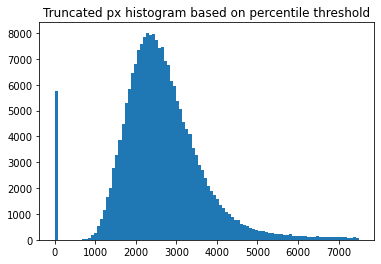

In [9]:


    var = local_variance_filter(im_large_np, radius=var_filt_radius)
    perc = np.percentile(var, perc_threshold)

    var_thr = var.copy()
    var_thr[var_thr < perc] = 0
    var_thr[var_thr >= perc] = 1

    plt.hist(var.flatten()[var.flatten()<perc], 100);
    plt.title('Truncated px histogram based on percentile threshold')



Text(0.5, 1.0, 'Binarised staurated variance')

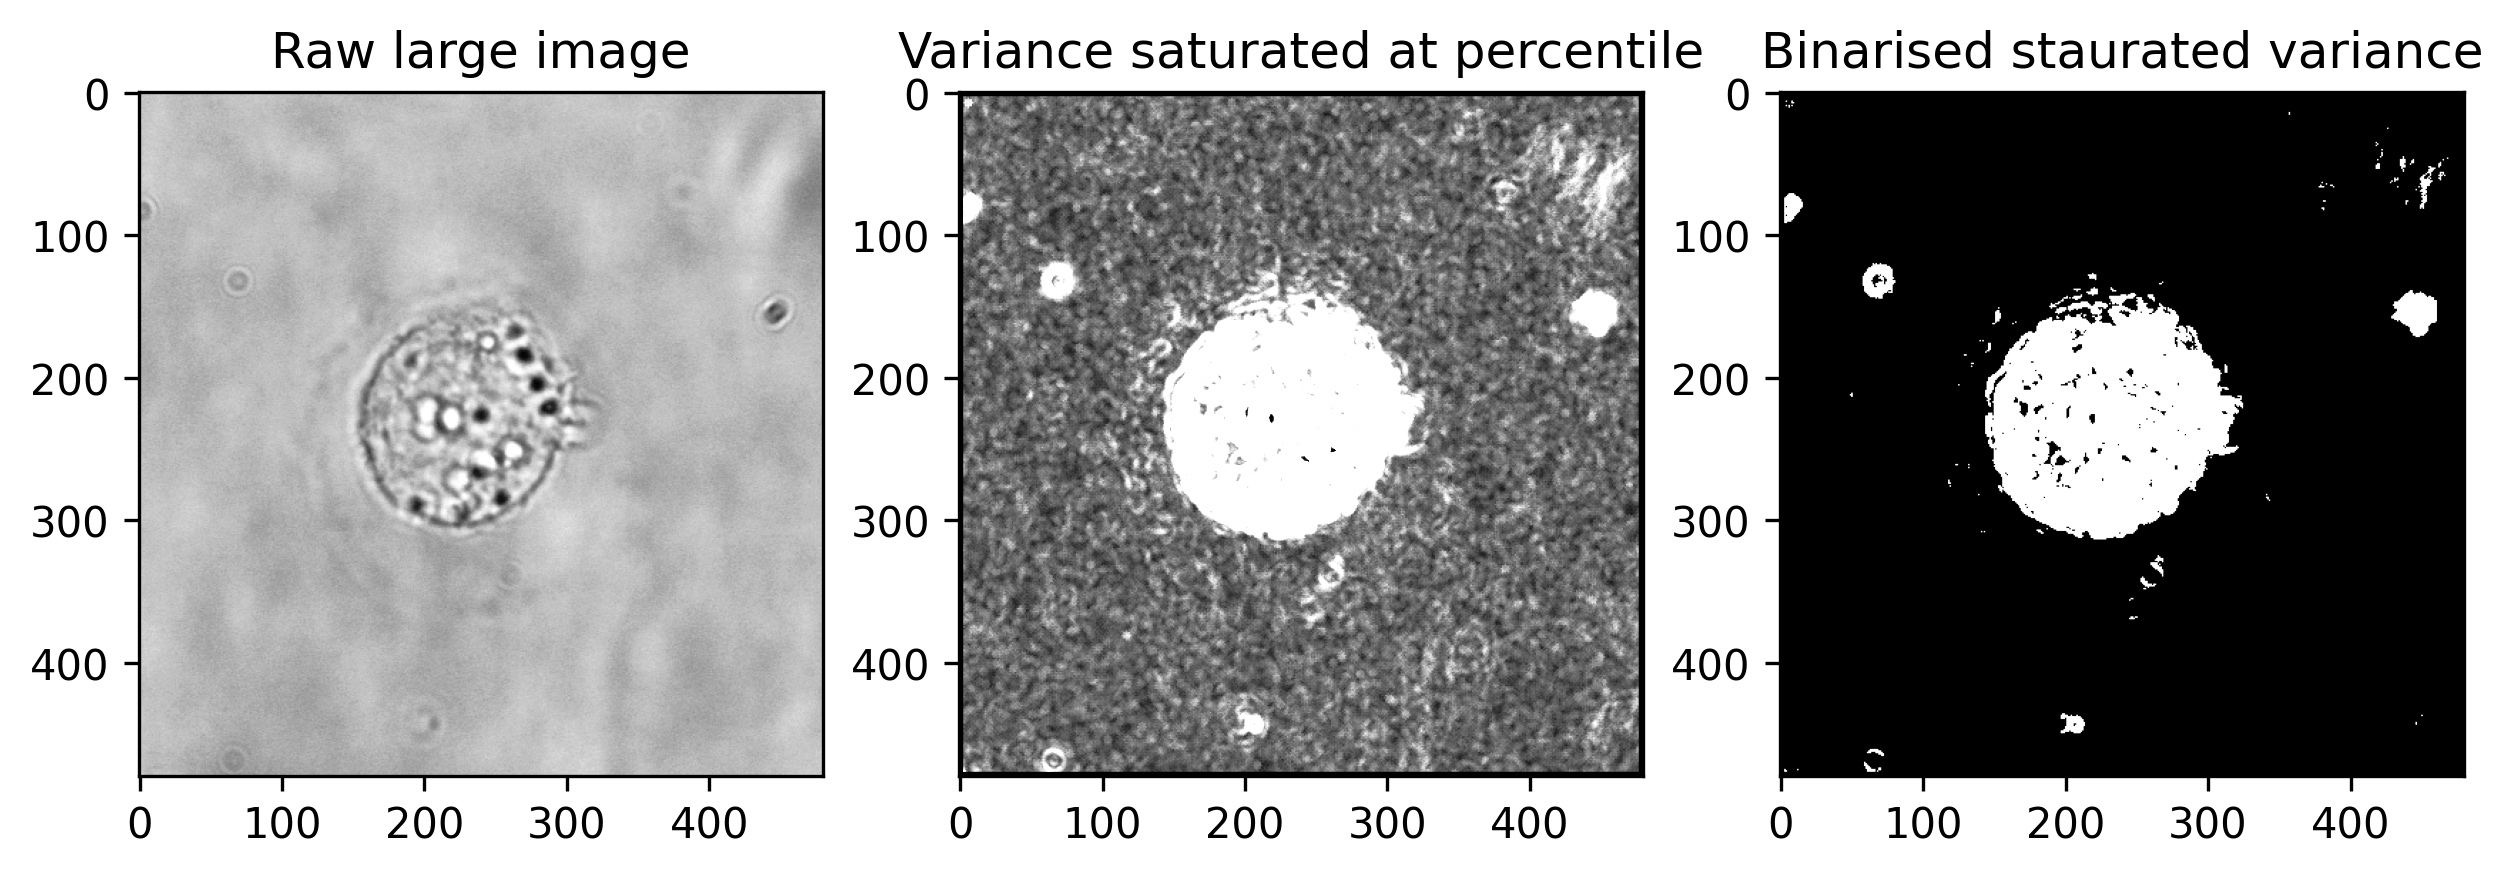

In [10]:


    _,axs = plt.subplots(1,3, figsize=(10,20), dpi=300)
    axs[0].imshow(im_large_np, cmap='Greys_r')
    axs[1].imshow(var, cmap='Greys_r', vmin=0, vmax=perc)
    axs[2].imshow(var_thr, cmap='Greys_r')

    axs[0].set_title('Raw large image')
    axs[1].set_title('Variance saturated at percentile')
    axs[2].set_title('Binarised staurated variance')



Text(0.5, 1.0, 'Binarised staurated variance (downsampled)')

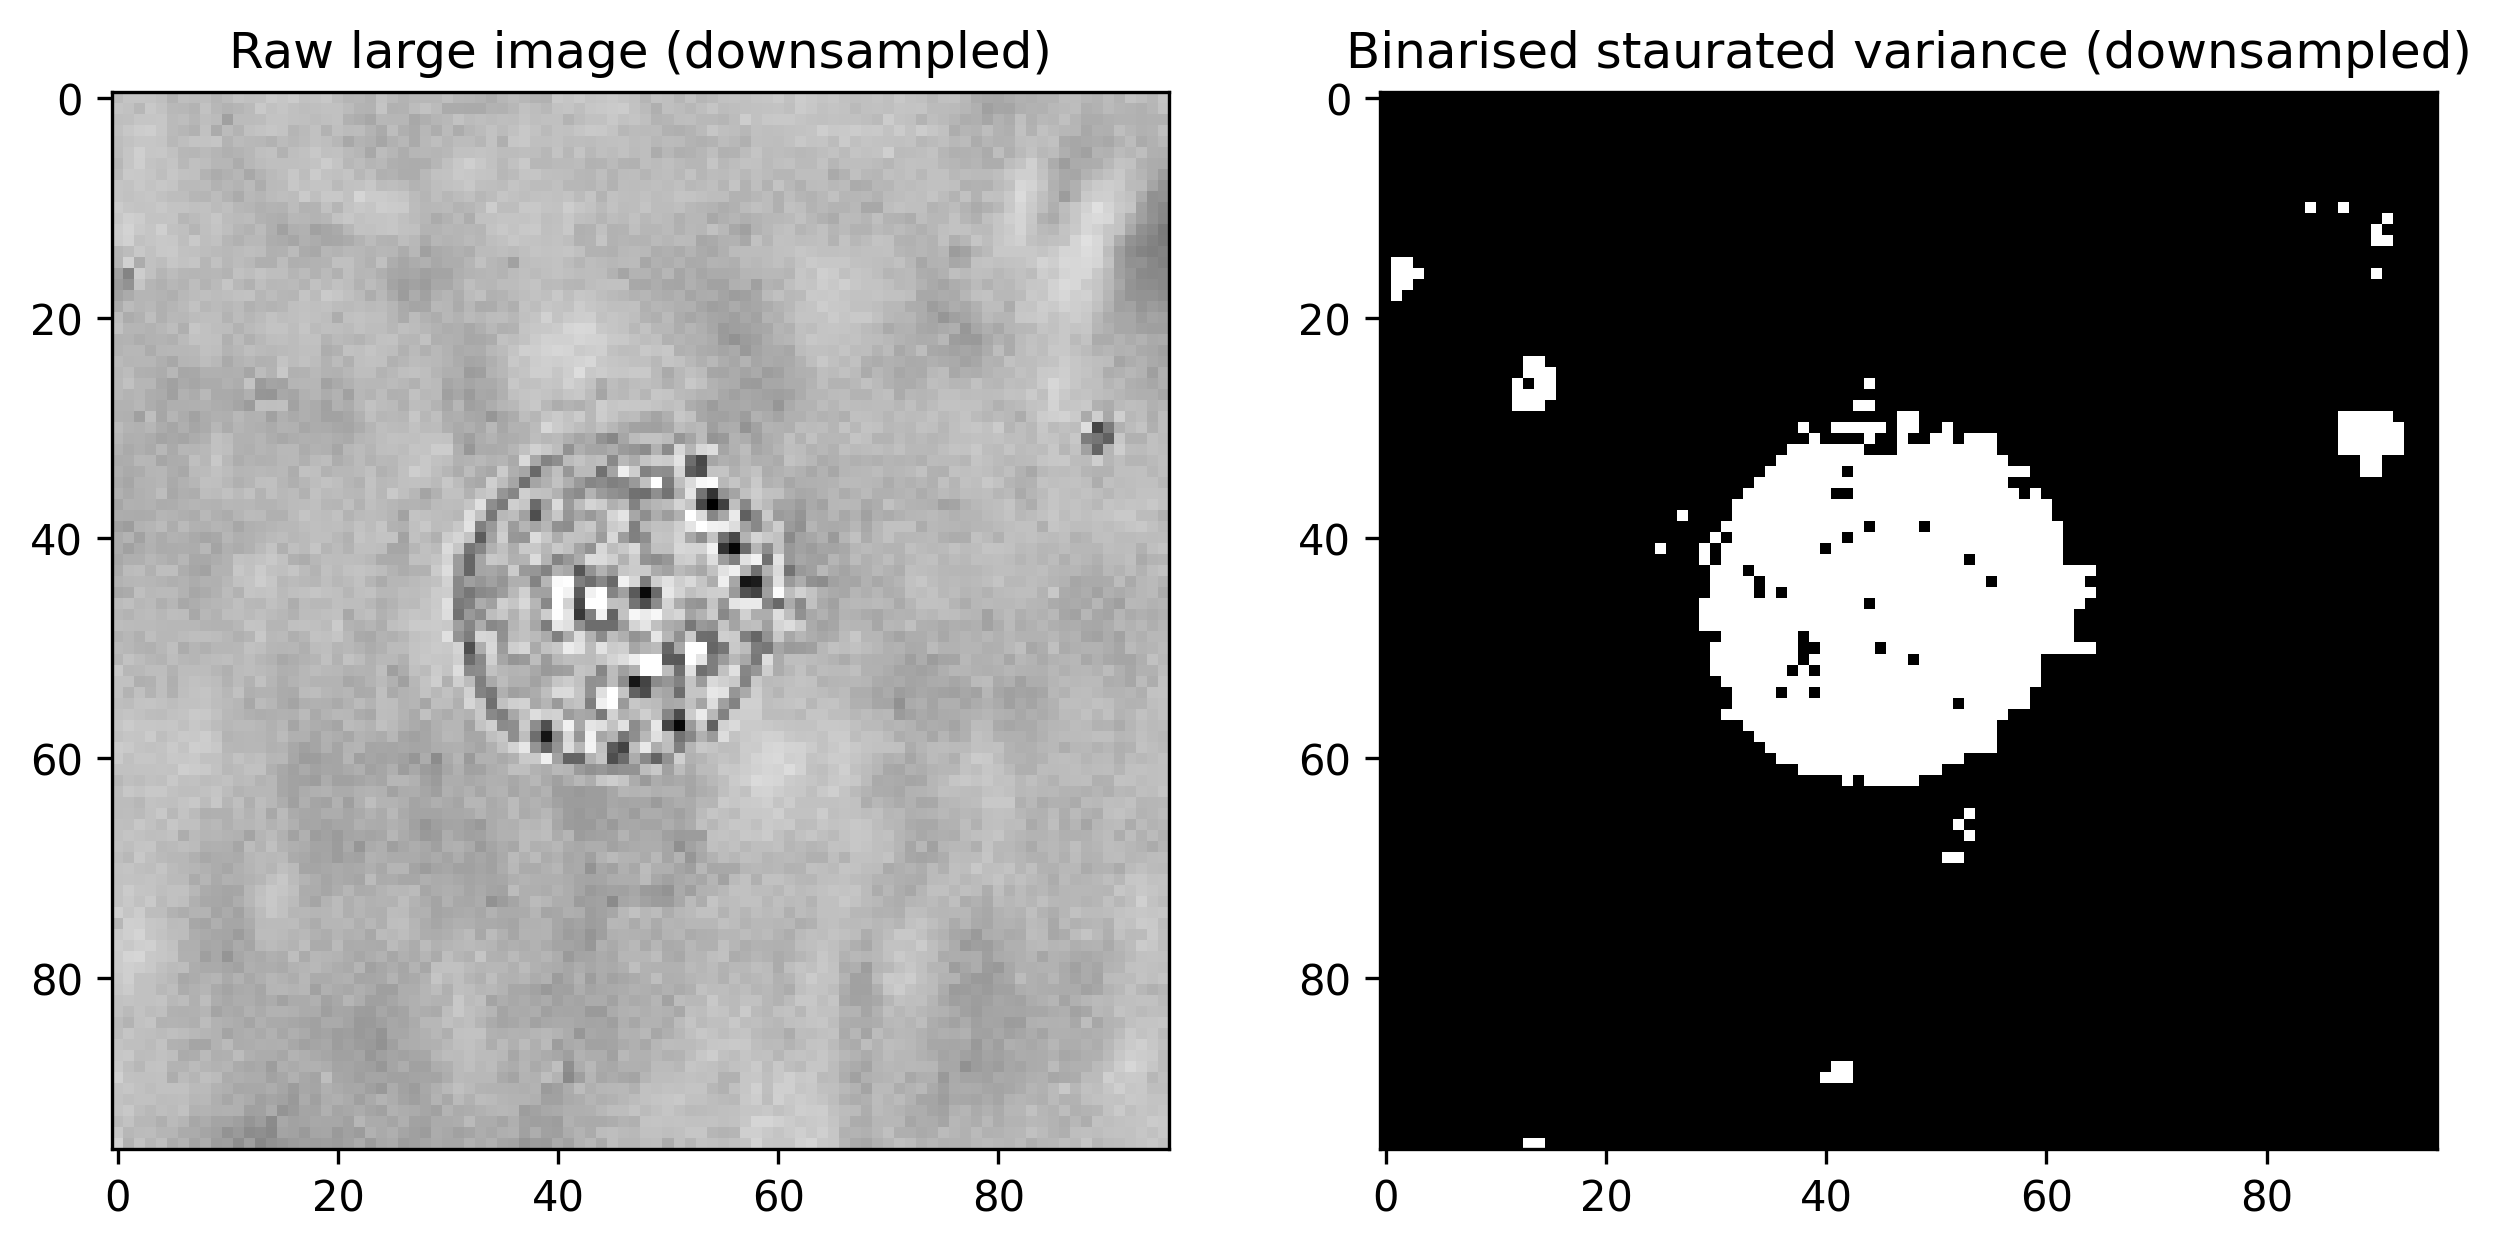

In [11]:
    var_thr_downs = var_thr[::resc_rat,::resc_rat]
    im_orig_downs = im_large_np[::resc_rat,::resc_rat]

    _,axs = plt.subplots(1,2, figsize=(10,20), dpi=300)
    axs[0].imshow(im_orig_downs, cmap='Greys_r')
    axs[1].imshow(var_thr_downs, cmap='Greys_r')

    axs[0].set_title('Raw large image (downsampled)')
    axs[1].set_title('Binarised staurated variance (downsampled)')

In [12]:
%timeit 
distance = distance_two_images(var_thr_downs, im_small_np)
res = position_of_min(distance)

the minimum distance is:  91923.82204101814
Tuple of arrays returned :  (array([31]), array([0]))


Text(0.5, 1.0, 'Optimal shift of small image')

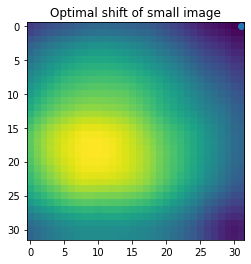

In [13]:
plt.imshow(distance.T)
plt.scatter(res[0][0], res[1][0])
plt.title('Optimal shift of small image')

In [17]:
im_small_np

array([[0.       , 5.763069 , 5.763069 , ..., 5.8481693, 5.8469963,
        0.       ],
       [5.8017955, 5.81307  , 5.809462 , ..., 5.875618 , 5.906266 ,
        5.875618 ],
       [5.771769 , 5.8014793, 5.79827  , ..., 5.9214716, 5.9034553,
        5.875618 ],
       ...,
       [5.800572 , 5.800572 , 5.780485 , ..., 5.9155164, 5.9014783,
        5.876565 ],
       [5.800572 , 5.825047 , 5.797072 , ..., 5.9155774, 5.9052243,
        5.876565 ],
       [0.       , 5.797072 , 5.789293 , ..., 5.9052243, 5.9014783,
        0.       ]], dtype=float32)

Text(0.5, 1.0, 'Overlay of small image and large image')

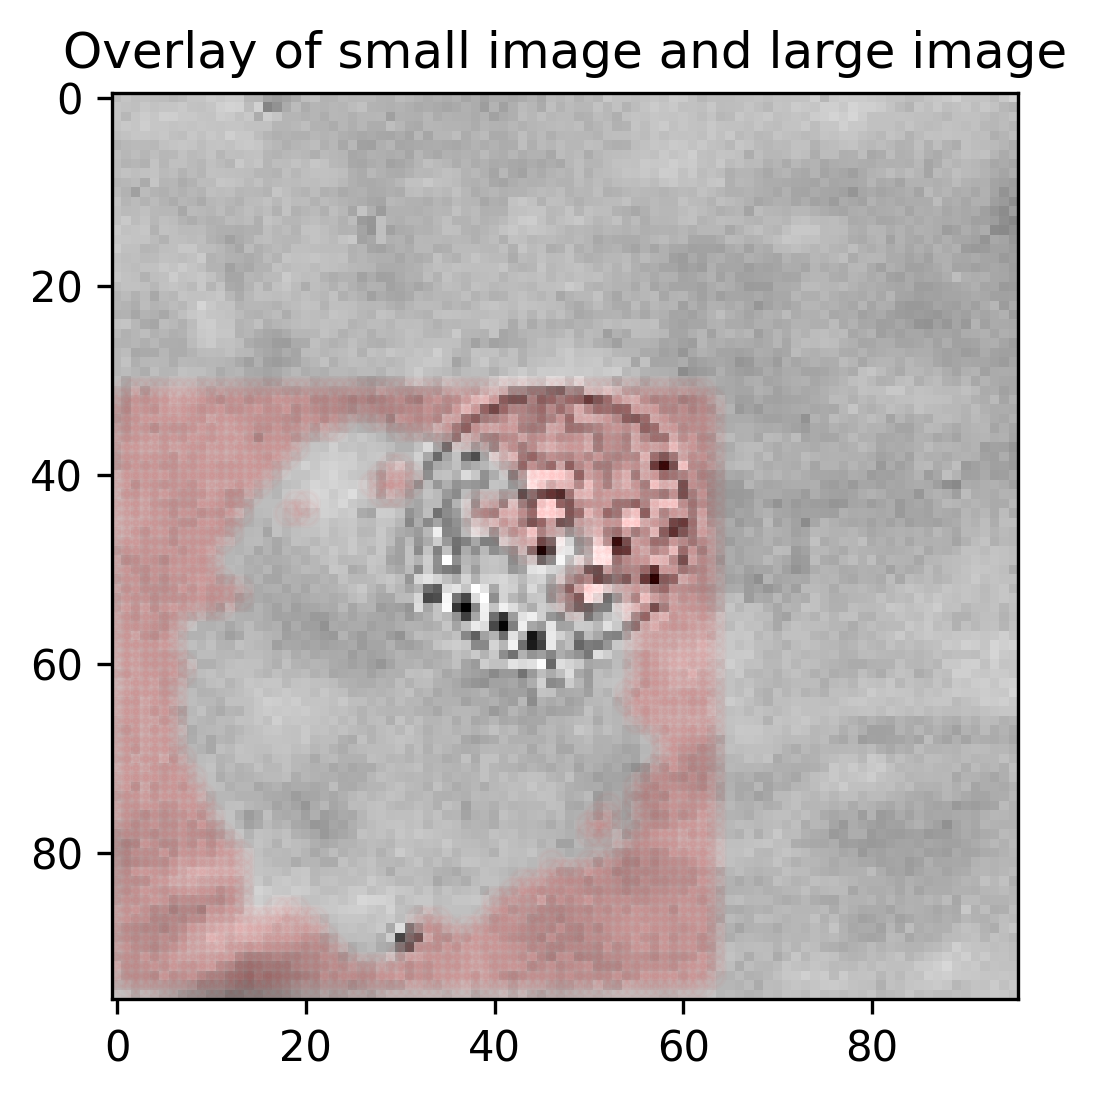

In [20]:
nonzero = np.where(im_small_np > thr_overlay_vis) # only for visualisation

plt.figure(dpi=300)
plt.imshow(im_orig_downs.T, cmap='Greys_r')
plt.scatter(res[1][0]+nonzero[1], res[0][0]+nonzero[0], alpha=0.02, c='red')
plt.title('Overlay of small image and large image')